Import Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

Load Dataset

In [2]:
url='https://drive.google.com/uc?id=1gnLO9qvEPqv1uBt1928AcsCmdvzqjC5m'
df = pd.read_csv(url)

In [3]:
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70.0,Doctor,81.0,1.0,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68.0,Doctor,141.0,1.0,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19.0,Student,56.0,1.0,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26.0,Student,25.0,1.0,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,NaN,Student,198.0,1.0,7429.40,2024-11-04 08:06:39


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2508 non-null   object 
 1   AccountID                2516 non-null   object 
 2   TransactionAmount        2511 non-null   float64
 3   TransactionDate          2509 non-null   object 
 4   TransactionType          2507 non-null   object 
 5   Location                 2507 non-null   object 
 6   DeviceID                 2507 non-null   object 
 7   IP Address               2517 non-null   object 
 8   MerchantID               2514 non-null   object 
 9   Channel                  2510 non-null   object 
 10  CustomerAge              2519 non-null   float64
 11  CustomerOccupation       2514 non-null   object 
 12  TransactionDuration      2511 non-null   float64
 13  LoginAttempts            2516 non-null   float64
 14  AccountBalance          

In [5]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2511.000000,2519.000000,2511.000000,2516.000000,2510.000000
mean,297.656468,44.678444,119.422939,1.121622,5113.438124
std,292.230367,17.837359,70.078513,0.594469,3897.975861
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.310000,27.000000,63.000000,1.000000,1504.727500
50%,211.360000,45.000000,112.000000,1.000000,4734.110000
75%,413.105000,59.000000,161.000000,1.000000,7672.687500
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


Exploratory Data Analysis (EDA)

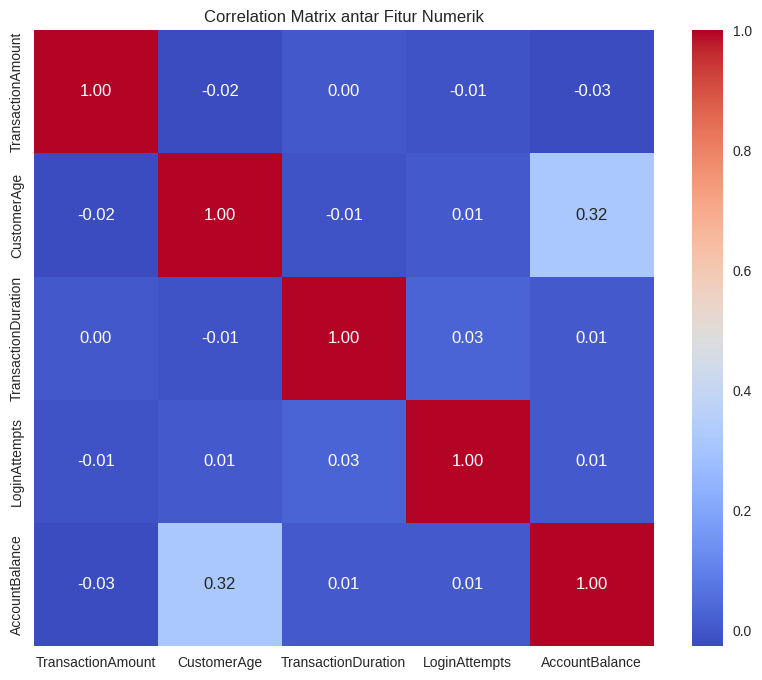

In [6]:
# Correlation between features
df_numeric = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = df_numeric.corr()

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix antar Fitur Numerik")
plt.show()


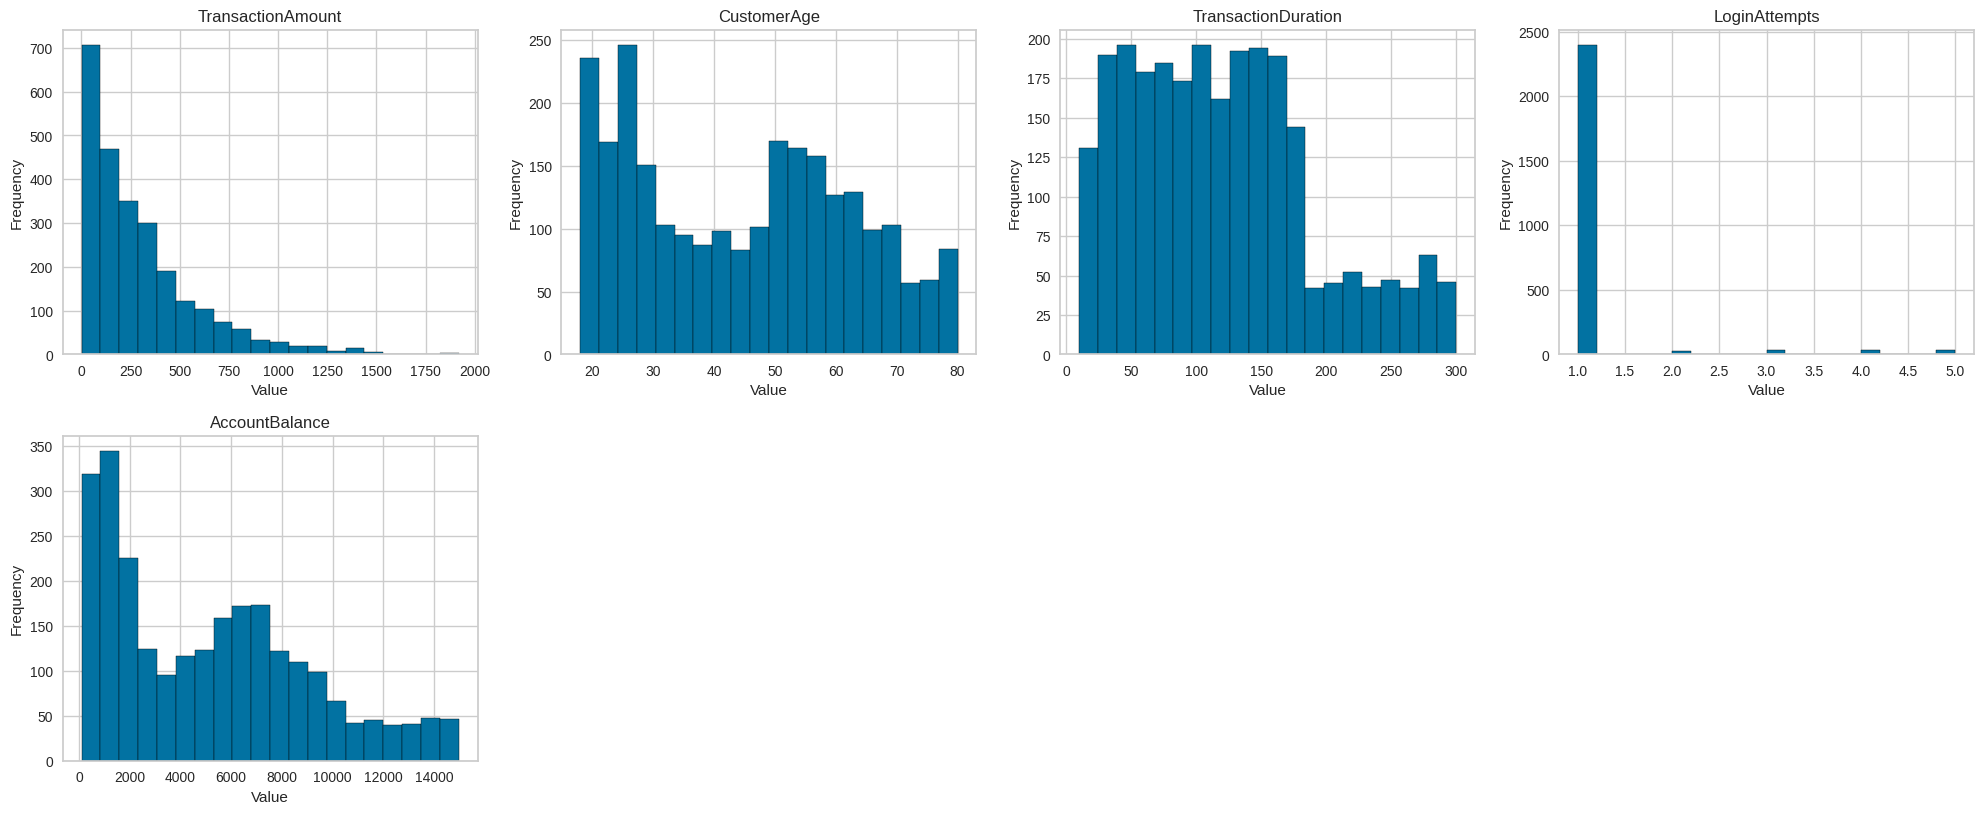

In [7]:
# Histogram for numeric
num_vars = df.shape[1]
n_cols = 4
n_rows = -(-num_vars // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

axes = axes.flatten()

# Plot
for i, column in enumerate(df.drop(columns=["TransactionID", "AccountID", "TransactionDate",
                                            "TransactionType", "Location", "DeviceID",
                                            "IP Address", "MerchantID", "Channel",
                                            "CustomerOccupation", "PreviousTransactionDate"]).columns):
    df[column].hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

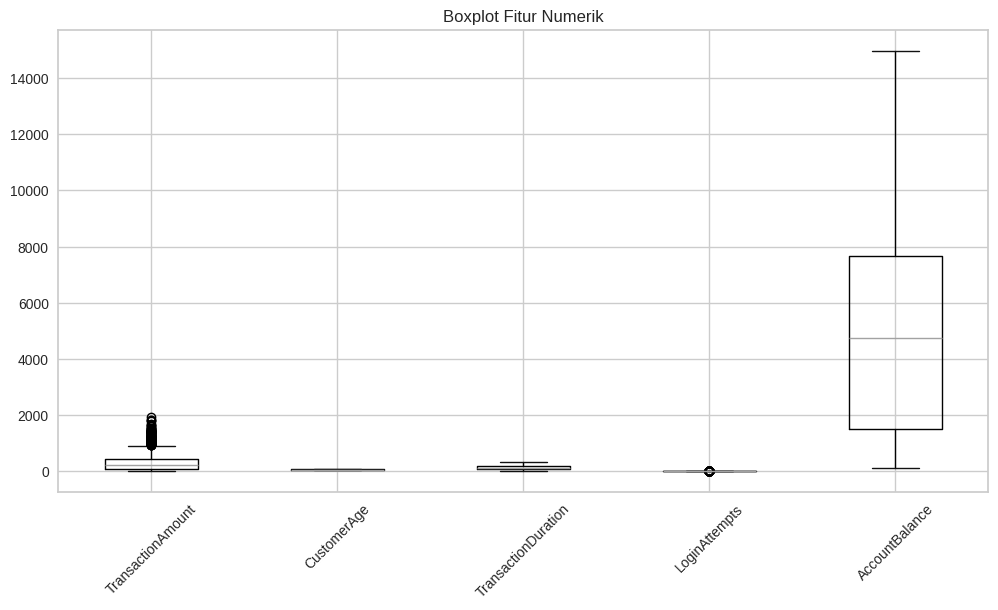

In [8]:
# Boxplot Numeric Features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot Fitur Numerik")
plt.show()

Pre-processing Data

In [9]:
# Check Missing Values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

,0
TransactionID,29
AccountID,21
TransactionAmount,26
TransactionDate,28
TransactionType,30
Location,30
DeviceID,30
IP Address,20
MerchantID,23
Channel,27


In [10]:
# Check Duplicates
duplicates_count = df.duplicated().sum()
print("Jumlah data duplikat:", duplicates_count)

Jumlah data duplikat: 21


In [11]:
# Feature Scaling
numeric_features = df.select_dtypes(include=['number']).columns
numeric_features

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,-0.970546,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,1.419862,Doctor,-0.548393,-0.204629,-0.000315,2024-11-04 08:08:08
1,TX000002,AC00455,0.268963,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,1.307715,Doctor,0.307960,-0.204629,2.218381,2024-11-04 08:09:35
2,TX000003,AC00019,-0.586526,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,-1.439874,Student,-0.905207,-0.204629,-1.024091,2024-11-04 08:07:04
3,TX000004,AC00070,-0.387294,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,-1.047361,Student,-1.347656,-0.204629,0.886694,2024-11-04 08:09:06
4,TX000005,AC00411,-0.972736,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,NaN,Student,1.121495,-0.204629,0.594263,2024-11-04 08:06:39


In [12]:
# Drop ID & IP Address
df = df.drop(columns=["TransactionID", "AccountID",  "DeviceID", "IP Address", "MerchantID"])

In [13]:
# Feature Encoding
label_encoder = LabelEncoder()

df['TransactionDate'] = label_encoder.fit_transform(df['TransactionDate'])
df['TransactionType'] = label_encoder.fit_transform(df['TransactionType'])
df['Location'] = label_encoder.fit_transform(df['Location'])
df['Channel'] = label_encoder.fit_transform(df['Channel'])
df['CustomerOccupation'] = label_encoder.fit_transform(df['CustomerOccupation'])
df['PreviousTransactionDate'] = label_encoder.fit_transform(df['PreviousTransactionDate'])

print(df.head())

   TransactionAmount  TransactionDate  TransactionType  Location  Channel  \
0          -0.970546              680                1        36        0   
1           0.268963             1178                1        15        0   
2          -0.586526             1262                1        23        2   
3          -0.387294              818                1        33        2   
4          -0.972736             1939                0         1        2   

   CustomerAge  CustomerOccupation  TransactionDuration  LoginAttempts  \
0     1.419862                   0            -0.548393      -0.204629   
1     1.307715                   0             0.307960      -0.204629   
2    -1.439874                   3            -0.905207      -0.204629   
3    -1.047361                   3            -1.347656      -0.204629   
4          NaN                   3             1.121495      -0.204629   

   AccountBalance  PreviousTransactionDate  
0       -0.000315                      105  
1 

In [14]:
# Last Checking
df.columns.tolist()

['TransactionAmount',
 'TransactionDate',
 'TransactionType',
 'Location',
 'Channel',
 'CustomerAge',
 'CustomerOccupation',
 'TransactionDuration',
 'LoginAttempts',
 'AccountBalance',
 'PreviousTransactionDate']

In [15]:
# Drop Missing Values & Duplicates
df = df.dropna()
df = df.drop_duplicates()

In [18]:
# Handling Outlier
def handle_outliers(df, method="drop", exclude_cols=None):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

    if exclude_cols:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        if method == "drop":
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        elif method == "impute":
            median = df_clean[col].median()
            df_clean[col] = np.where(df_clean[col] < lower, median, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper, median, df_clean[col])

    return df_clean

In [21]:
# Check Outlier
def check_outliers(df, exclude_cols=None):
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if exclude_cols:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    outlier_summary = {}
    total_rows = df.shape[0]

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_summary[col] = {
            "count": outliers.shape[0],
            "percent": (outliers.shape[0] / total_rows) * 100
        }

    return pd.DataFrame(outlier_summary).T

exclude_cols = ["TransactionAmount", "TransactionType", "Location", "Channel", "CustomerOccupation"]

df_no_outliers = handle_outliers(df, method="drop", exclude_cols=exclude_cols)

print("\nOutlier:")
print(check_outliers(df_no_outliers, exclude_cols=exclude_cols))


Outlier:
                         count  percent
TransactionDate            0.0      0.0
CustomerAge                0.0      0.0
TransactionDuration        0.0      0.0
LoginAttempts              0.0      0.0
AccountBalance             0.0      0.0
PreviousTransactionDate    0.0      0.0


In [22]:
# Binning
df_binned = df_no_outliers.copy()

# Binning CustomerAge
df_binned['AgeGroup'] = pd.cut(
    df_binned['CustomerAge'],
    bins=[-np.inf, -1, 0, 1, np.inf],
    labels=['Young', 'Adult', 'Middle', 'Senior']
)

# Binning TransactionAmount
df_binned['AmountGroup'] = pd.cut(
    df_binned['TransactionAmount'],
    bins=[-np.inf, -1, 0, 1, np.inf],
    labels=['VeryLow', 'Low', 'High', 'VeryHigh']
)

# Encode
le = LabelEncoder()
df_binned['AgeGroup_enc'] = le.fit_transform(df_binned['AgeGroup'].astype(str))
df_binned['AmountGroup_enc'] = le.fit_transform(df_binned['AmountGroup'].astype(str))

print(df_binned[['CustomerAge', 'AgeGroup', 'AgeGroup_enc']].head())
print(df_binned[['TransactionAmount', 'AmountGroup', 'AmountGroup_enc']].head())

   CustomerAge AgeGroup  AgeGroup_enc
0     1.419862   Senior             2
1     1.307715   Senior             2
2    -1.439874    Young             3
3    -1.047361    Young             3
5    -1.495947    Young             3
   TransactionAmount AmountGroup  AmountGroup_enc
0          -0.970546         Low                1
1           0.268963        High                0
2          -0.586526         Low                1
3          -0.387294         Low                1
5          -0.703375         Low                1


Clustering

In [23]:
df.describe()

,TransactionAmount,TransactionDate,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
count,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000
mean,-0.000425,1256.404921,0.788574,21.383653,1.013344,-0.003388,1.532110,0.000832,-0.002560,-0.006050,180.984987
std,0.997561,726.716182,0.437979,12.417622,0.831075,1.000136,1.153802,1.003159,0.989711,1.001030,103.757245
min,-1.017881,0.000000,0.000000,0.000000,0.000000,-1.495947,0.000000,-1.561745,-0.204629,-1.286100,0.000000
25%,-0.737943,626.250000,1.000000,11.000000,0.000000,-0.991288,0.000000,-0.805299,-0.204629,-0.929992,92.000000
50%,-0.290005,1254.500000,1.000000,21.000000,1.000000,0.018031,2.000000,-0.105944,-0.204629,-0.110335,181.000000
75%,0.389115,1884.750000,1.000000,32.000000,2.000000,0.803056,3.000000,0.607683,-0.204629,0.652406,271.750000
max,5.549651,2485.000000,2.000000,43.000000,3.000000,1.980594,4.000000,2.577295,6.525404,2.531190,360.000000


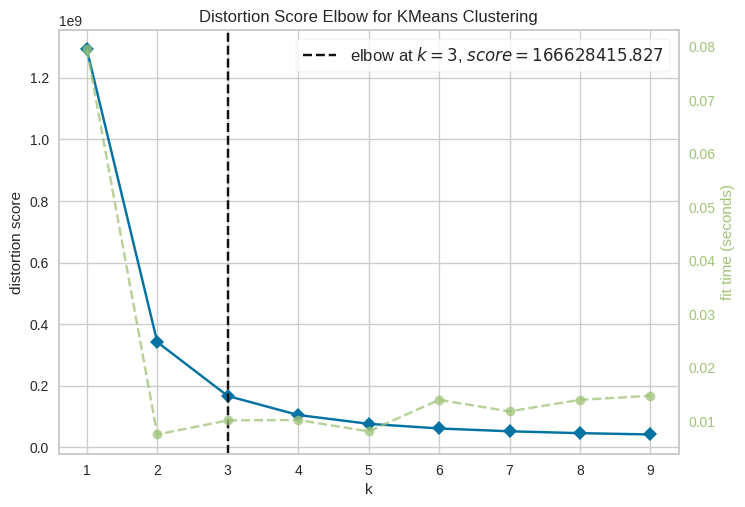

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
# Elbow Method Visualization
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

visualizer.fit(df)
visualizer.show()

In [25]:
# K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df)

labels = kmeans.labels_
k = 3

def analyze_clusters(X, labels, k):
    print("Analisis Karakteristik Setiap Cluster:")
    for cluster_id in range(k):
        cluster_data = X[labels == cluster_id]

        print(f"\nCluster {cluster_id + 1}:")
        for col in cluster_data.columns:
            print(f"Rata-rata {col}: {cluster_data[col].mean():.2f}")

analyze_clusters(df, labels, k)

Analisis Karakteristik Setiap Cluster:

Cluster 1:
Rata-rata TransactionAmount: 0.03
Rata-rata TransactionDate: 2094.70
Rata-rata TransactionType: 0.77
Rata-rata Location: 21.51
Rata-rata Channel: 1.05
Rata-rata CustomerAge: -0.01
Rata-rata CustomerOccupation: 1.52
Rata-rata TransactionDuration: 0.02
Rata-rata LoginAttempts: 0.01
Rata-rata AccountBalance: 0.03
Rata-rata PreviousTransactionDate: 181.03

Cluster 2:
Rata-rata TransactionAmount: -0.03
Rata-rata TransactionDate: 417.86
Rata-rata TransactionType: 0.80
Rata-rata Location: 20.91
Rata-rata Channel: 0.98
Rata-rata CustomerAge: -0.06
Rata-rata CustomerOccupation: 1.51
Rata-rata TransactionDuration: -0.04
Rata-rata LoginAttempts: 0.04
Rata-rata AccountBalance: -0.01
Rata-rata PreviousTransactionDate: 184.93

Cluster 3:
Rata-rata TransactionAmount: 0.00
Rata-rata TransactionDate: 1253.49
Rata-rata TransactionType: 0.79
Rata-rata Location: 21.73
Rata-rata Channel: 1.01
Rata-rata CustomerAge: 0.06
Rata-rata CustomerOccupation: 1.57
R

In [29]:
# Saved Model K-Means
joblib.dump(kmeans, "model_clustering.h5")

['model_clustering.h5']

In [30]:
# Silhouette Score.
score = silhouette_score(df, labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.5403


In [31]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)
data_final = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

kmeans_pca = KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit(data_final)

data_final['Cluster'] = kmeans_pca.labels_

print(data_final.head())

         PCA1        PCA2  Cluster
0 -576.251254  -77.177792        1
1  -78.427676   10.886261        2
2    5.871084 -139.979252        2
3 -438.366312  -18.895061        1
4 -621.071597 -169.234265        1


In [32]:
# Saved Model PCA
joblib.dump(pca, "PCA_model_clustering.h5")

['PCA_model_clustering.h5']

Cluster Interpretation

In [33]:
deskriptif = df.groupby(labels).agg(['mean', 'min', 'max', 'median', 'std'])
print(deskriptif)

  TransactionAmount                                         TransactionDate  \
               mean       min       max    median       std            mean   
0          0.027419 -1.017881  5.248151 -0.282133  1.047687     2094.704489   
1         -0.031922 -1.015827  5.244659 -0.307478  0.953507      417.861076   
2          0.003132 -1.017676  5.549651 -0.297381  0.989366     1253.494354   

                                   ... AccountBalance                      \
    min   max  median         std  ...           mean       min       max   
0  1673  2485  2096.5  242.775886  ...       0.028952 -1.286100  2.531190   
1     0   836   417.0  240.964633  ...      -0.013638 -1.285856  2.522155   
2   835  1672  1253.0  242.780970  ...      -0.033663 -1.281807  2.520287   

                      PreviousTransactionDate                              
     median       std                    mean min  max median         std  
0 -0.039802  1.010617              181.027431   0  360  180.5  105

Cluster 0: (Nasabah Bertansaksi an Pendapatan Besar)
- TransactionAmount: rata-rata positif (0.027) yang berarti transaksi cenderung lebih besar dibanding cluster lain.
- TransactionDate: 2094, yang berarti transaksi terjadi di periode akhir dataset (late users).
- AccountBalance: mean 0.029, yang berarti saldo relatif lebih tinggi dari cluster lain.
- PreviousTransactionDate: 181, yang berarti transaksi berulang di pertengahan periode.
- Analisis: Cluster ini berisi nasabah dengan saldo cukup besar, transaksi bernilai lebih tinggi, dan lebih aktif di periode akhir data. Bisa diasosiasikan dengan pelanggan mapan atau aktif belakangan.


Cluster 1: (Nasabah lama dan daya beli rendah)

- TransactionAmount: rata-rata negatif (-0.032), yang berarti transaksi relatif lebih kecil.
- TransactionDate: 418 → transaksi lebih sering di awal periode dataset.
- AccountBalance: mean -0.014, yang berarti saldo relatif lebih rendah.
- PreviousTransactionDate: 185,transaksi berulang mirip cluster 0.
- Analisis: Cluster ini mewakili nasabah dengan saldo lebih rendah dan nominal transaksi kecil, aktif di awal periode dataset. Bisa diasosiasikan dengan nasabah lama, tapi dengan daya beli rendah.


Cluster 2: (Nasabah biasa dan stabil)

- TransactionAmount: rata-rata mendekati nol (0.003), yang berarti transaksi cukup moderat.
- TransactionDate: 1253, yang berarti aktivitas banyak terjadi di pertengahan dataset.
- AccountBalance: mean -0.034, yang berarti saldo relative lebih rendah dibanding cluster lain.
- PreviousTransactionDate: 177, yang berarti transaksi lebih sering di pertengahan periode.
- Analisis: Cluster ini adalah nasabah dengan saldo lebih rendah, aktivitas moderat, dan aktif di pertengahan periode. Bisa diasosiasikan dengan nasabah biasa, stabil, tapi bukan pengguna bernilai tinggi.

Export Data

In [34]:
df['Target'] = labels
df.to_csv('data_clustering.csv', index=False)

In [35]:
# Inverse dataset to normal range for numerical
df[numeric_cols] = scaler.inverse_transform(df[numeric_cols])
df.head()

,TransactionAmount,TransactionDate,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Target
0,14.09,680,1,36,0,70.0,0,81.0,1.0,5112.21,105,1
1,376.24,1178,1,15,0,68.0,0,141.0,1.0,13758.91,192,2
2,126.29,1262,1,23,2,19.0,3,56.0,1.0,1122.35,41,2
3,184.50,818,1,33,2,26.0,3,25.0,1.0,8569.06,163,1
5,92.15,635,1,28,0,18.0,3,172.0,1.0,781.68,13,1


In [36]:
# Inverse the encoded dataset to its original categories
categorical_cols = [
    'TransactionDate',
    'TransactionType',
    'Location',
    'Channel',
    'CustomerOccupation',
    'PreviousTransactionDate'
]

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

for col in categorical_cols:
    encoder = encoders[col]
    df[col] = encoder.inverse_transform(df[col].astype(int))

df.head()

,TransactionAmount,TransactionDate,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Target
0,14.09,680,1,36,0,70.0,0,81.0,1.0,5112.21,105,1
1,376.24,1178,1,15,0,68.0,0,141.0,1.0,13758.91,192,2
2,126.29,1262,1,23,2,19.0,3,56.0,1.0,1122.35,41,2
3,184.50,818,1,33,2,26.0,3,25.0,1.0,8569.06,163,1
5,92.15,635,1,28,0,18.0,3,172.0,1.0,781.68,13,1


In [37]:
# Descriptive analysis
df['Cluster'] = labels

desc_numeric = df.groupby('Cluster')[numeric_cols].agg(['mean', 'min', 'max'])

desc_categorical = df.groupby('Cluster')[categorical_cols].agg(lambda x: x.mode()[0])

print("Analisis Numerik per Cluster")
print(desc_numeric)
print("\n Analisis Kategorikal per Cluster")
print(desc_categorical)

Analisis Numerik per Cluster
        TransactionAmount                CustomerAge              \
                     mean   min      max        mean   min   max   
Cluster                                                            
0              305.667431  0.26  1831.02   44.564838  18.0  80.0   
1              288.329875  0.86  1830.00   43.565707  18.0  80.0   
2              298.571405  0.32  1919.11   45.726474  18.0  80.0   

        TransactionDuration              LoginAttempts            \
                       mean   min    max          mean  min  max   
Cluster                                                            
0                120.826683  10.0  300.0      1.125935  1.0  5.0   
1                116.790989  10.0  299.0      1.145181  1.0  5.0   
2                120.824341  10.0  299.0      1.089084  1.0  5.0   

        AccountBalance                    
                  mean     min       max  
Cluster                                   
0          5226.269701  

In [38]:
# Reintegrate the inverted data with the cluster results.
print(len(labels), df.shape[0])
df['Cluster'] = labels
df.head()

2398 2398


,TransactionAmount,TransactionDate,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Target,Cluster
0,14.09,680,1,36,0,70.0,0,81.0,1.0,5112.21,105,1,1
1,376.24,1178,1,15,0,68.0,0,141.0,1.0,13758.91,192,2,2
2,126.29,1262,1,23,2,19.0,3,56.0,1.0,1122.35,41,2,2
3,184.50,818,1,33,2,26.0,3,25.0,1.0,8569.06,163,1,1
5,92.15,635,1,28,0,18.0,3,172.0,1.0,781.68,13,1,1


In [39]:
# Saved Data
df.to_csv('data_clustering_inverse.csv', index=False)